# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [1]:
# For deep neural networks
import tensorflow.compat.v1 as tf

# For data representation
import numpy as np
import random

# For handling files
import os

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
env = gym.make("Asterix-v0")
# I have installed pyglet-1.5.11 for it work with BigSur

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [2]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(210, 160, 3)
Action space: Discrete(9)


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

In [3]:
class RandomAgent():
    def __init__(self, env):
        self.action_size = env.action_space.n
        
    def get_action(self, observation):
        return random.choice(range(self.action_size))
    
total_reward=0
agent = RandomAgent(env)
numberOfEpisodes = 10
# for steps in range(numberOfEpisodes):
#     current_obs = env.reset()
#     done = False
#     while not done:
#         action = agent.get_action(current_obs)
#         next_obs, reward, done, info = env.step(action)
#         total_reward += reward
#         env.render()
print("Average reward: {}".format(total_reward/numberOfEpisodes))

Average reward: 0.0


### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


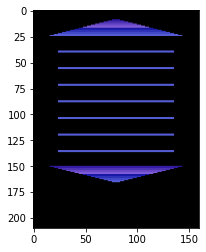

float32


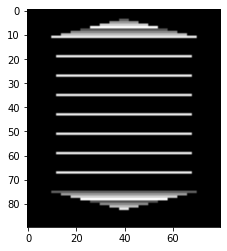

In [4]:
obs = env.reset()
from skimage.color import rgb2gray

def preprocess_observation(observation):
    img = observation[1:180:2, ::2] # This becomes 96, 80, 3
#     print(img.shape)
#     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
    img = rgb2gray(img)
    img = img.astype(np.float32) # normalize from -128 to 127
    return img.reshape(-1, 90, 80, 1)

plt.imshow(obs)
plt.show()
print(preprocess_observation(obs)[0].dtype)
plt.imshow(preprocess_observation(obs).reshape(90,80), cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [34]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

INPUT_SHAPE = (90, 80, 1)
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [46]:
from collections import deque

class QLearningAgent():
    def __init__(self, env):
        self.memory = deque(maxlen=2000)
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        tf.reset_default_graph()
        tf.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()

        # Saving the session
#         self.saver = tf.train.Saver()
#         self.sess = tf.Session()
#         if os.path.isfile(self.checkpoint_path + ".index"):
#             self.saver.restore(self.sess, self.checkpoint_path)
#         else:
#             self.sess.run(tf.global_variables_initializer())
#             self.sess.run(self.copy_online_to_target)

    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        # reset_random_seeds()

        # Build the model
        model = Sequential()
        model.add(Conv2D(32, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE))
        model.add(Conv2D(64, kernel_size=4, padding="same", strides=2, activation='relu'))
        model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(NUM_ACTIONS, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        epsilon = max(0.1, 1 - (0.9/2000000) * step)
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_size) # random action
        else:
            q_values = self.online.predict(state)
            return np.argmax(q_values) # optimal action
    
    def train(self, state, action, reward, new_state, done):
        """Train the online model and update the loss value
        """
#         print()
#         print(state.shape, type(state))
#         input()
#         if len(self.memory) < BATCH_SIZE:
#             return
#         samples = random.sample(self.memory, BATCH_SIZE)
#         states = np.array([state.reshape(90,80,1) for state, *other in samples])
#         targets = self.target.predict(states)
#         print()
#         print(targets, states.shape)
#         input()
        
        target = self.target.predict(state)
        if done:
            target[0][action] = reward
        else:
            Q_future = np.amax(self.target.predict(new_state)[0])
            target[0][action] = reward + Q_future * self.discount_rate
#             targets.append(target)
        hist = self.online.fit(state, target, epochs=1, verbose=0)
        self.loss_val = hist.history['loss'][0]
    
    def save_to_memory(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [47]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
total_reward = 0
n_steps = 1000000  # total number of training steps
copy_steps = 5000
save_steps = 1000 

# Train the model after 4 actions
train_online_steps = 4

# Train the model after 4 actions
# Considered as a hyperparameter
update_target_steps = 5000

done=True
for step in range(n_steps):
    print("\r\tAction step: {}/{} ({:.1f}%)\tLoss: {:5f}".format(
        step,
        n_steps,
        step * 100 / n_steps, 
        agent.loss_val), end="")

    if done: # game over, start again
        obs = env.reset()
        ep_rewards.append(total_reward)
        total_reward = 0
        state = preprocess_observation(obs)

    total_perc = int(step * 100 / n_steps)

    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_obs, reward, done, info = env.step(action)
    next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done)
    
    if step % train_online_steps == 0:
        agent.train(state, action, reward, next_state, done)

    env.render()
    total_reward += reward
    state = next_state
    # Regularly copy the online DQN to the target DQN
    if step % update_target_steps == 0:
        agent.update_target()
#     # And save regularly
#     if step % save_steps == 0:
#         agent.saver.save(agent.sess, agent.checkpoint_path)
env.close()

	Action step: 32/1000000 (0.0%)	Loss:   inf

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



[[ 3.35909612e-03  6.93080062e-03 -1.39201060e-04 -1.56468935e-02
   5.28904423e-03 -1.19875930e-02 -8.41046311e-03 -4.68712859e-03
   1.39762852e-02]
 [ 4.65540122e-03  1.29469056e-02  2.70340126e-04 -2.30806805e-02
   1.93149084e-04 -6.37060916e-03  3.67169734e-04 -7.82597251e-03
   2.32247785e-02]
 [-8.84171575e-04  1.53806657e-02  2.23951414e-04 -1.33261085e-02
   8.32868274e-04 -1.13604665e-02 -1.08824600e-03 -5.92892803e-03
   1.90251172e-02]
 [ 2.54053809e-03  1.07753901e-02  3.96577362e-03 -1.71638057e-02
  -5.58109023e-05 -1.12543004e-02 -6.31460454e-03 -8.53031315e-03
   1.69306416e-02]
 [ 3.90016474e-04  7.27119297e-03  5.24228998e-03 -1.99069045e-02
  -2.38533947e-03 -1.33385845e-02 -8.19846429e-03 -1.73275883e-03
   1.10662393e-02]
 [ 5.93808480e-04  8.85098800e-03  4.04955447e-03 -2.36082654e-02
   5.18029230e-03 -9.50827263e-03  1.13156624e-03 -8.76346976e-03
   1.21871512e-02]
 [-4.28344589e-03  1.21870395e-02 -1.04781357e-03 -1.66366100e-02
  -1.69711863e-03 -7.598693

KeyboardInterrupt: Interrupted by user

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k